<a href="https://colab.research.google.com/github/taniasuchi07/Technical-Assessment/blob/main/A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy as sp
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/malaysia_unemployment.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('M')                  # Set frequency explicitly to monthly

In [ ]:
df.describe()

,Unemployment,GDP,Inflation
count,189.000000,189.000000,189.000000
mean,4.489044,4.062512,1.958521
std,0.465209,0.924758,0.514089
min,3.500000,1.000000,0.764178
25%,4.159988,3.399783,1.595851
50%,4.493251,4.081874,1.943836
75%,4.760971,4.662131,2.288536
max,5.860085,6.500000,3.539440


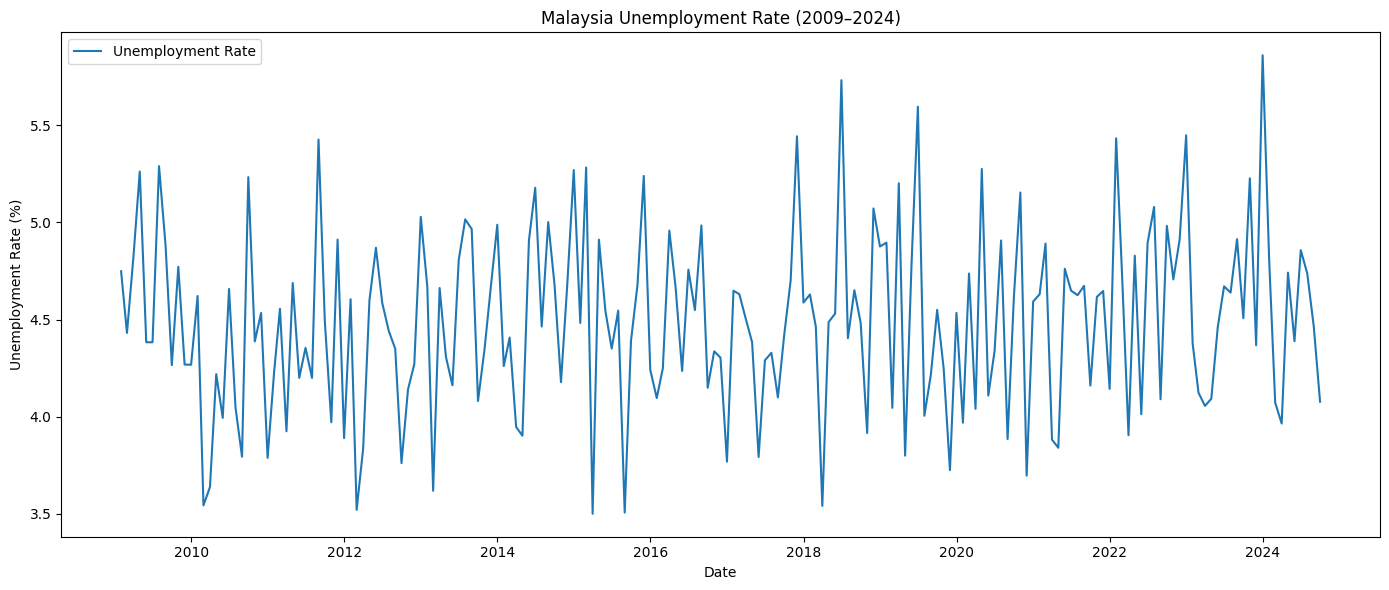

In [ ]:
# Plot time series
plt.figure(figsize=(14,6))
plt.plot(df.index, df['Unemployment'], label='Unemployment Rate')
plt.title('Malaysia Unemployment Rate (2009–2024)')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.tight_layout()
plt.savefig("unemployment_trend.png")
plt.show()

In [ ]:
# Train-Test Split
# Train-Test Split
train = df[:'2022']
test = df['2023':]

#train = df['Unemployment'][:'2022']
#test = df['Unemployment']['2023':]

In [ ]:
# ARIMA Model

arima_model = ARIMA(train['Unemployment'], order=(1,1,1))
arima_result = arima_model.fit()
forecast_arima = arima_result.forecast(steps=len(test))


                               SARIMAX Results                                
Dep. Variable:           Unemployment   No. Observations:                  168
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -112.119
Date:                Wed, 04 Jun 2025   AIC                            230.237
Time:                        11:06:02   BIC                            239.591
Sample:                    01-31-2009   HQIC                           234.034
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0721      0.092     -0.782      0.434      -0.253       0.109
ma.L1         -0.9846      0.034    -28.851      0.000      -1.052      -0.918
sigma2         0.2194      0.026      8.417      0.0

In [ ]:
# SARIMA Model
sarima_model = SARIMAX(train['Unemployment'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit()
forecast_sarima = sarima_result.forecast(steps=len(test))

In [ ]:
# ETS Model
ets_model = ExponentialSmoothing(train['Unemployment'], seasonal='add', seasonal_periods=12)
ets_result = ets_model.fit()
forecast_ets = ets_result.forecast(len(test))

In [ ]:
# VAR Model

var_data = df[['Unemployment', 'GDP', 'Inflation']].dropna()
train_var = var_data[:'2022']
test_var = var_data['2023':]

model_var = VAR(train_var)
results_var = model_var.fit(2)
forecast_var = results_var.forecast(train_var.values[-2:], steps=len(test_var))
forecast_var_df = pd.DataFrame(forecast_var, index=test_var.index, columns=train_var.columns)


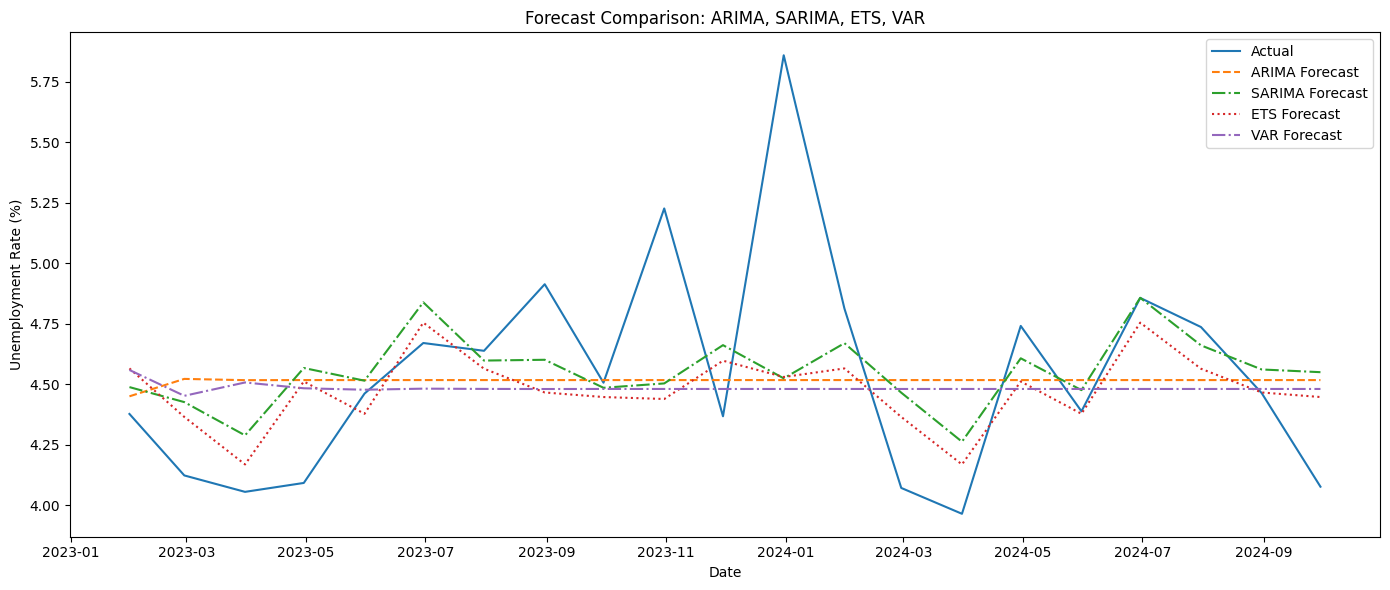

In [ ]:
# Plot Forecasts
plt.figure(figsize=(14,6))
plt.plot(test.index, test['Unemployment'], label='Actual')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast', linestyle='--')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast', linestyle='-.')
plt.plot(test.index, forecast_ets, label='ETS Forecast', linestyle=':')
plt.plot(test_var.index, forecast_var_df['Unemployment'], label='VAR Forecast', linestyle='dashdot')
plt.title('Forecast Comparison: ARIMA, SARIMA, ETS, VAR')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.tight_layout()
plt.savefig("forecast_comparison_all_models.png")
plt.show()

In [ ]:
# Evaluation Function
def evaluate(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

In [ ]:
# Model Evaluations

mae_arima, rmse_arima, mape_arima = evaluate(test['Unemployment'], forecast_arima)
mae_sarima, rmse_sarima, mape_sarima = evaluate(test['Unemployment'], forecast_sarima)
mae_ets, rmse_ets, mape_ets = evaluate(test['Unemployment'], forecast_ets)
mae_var, rmse_var, mape_var = evaluate(test_var['Unemployment'], forecast_var_df['Unemployment'])

print("Model Performance Comparison:")
print("ARIMA : MAE={:.3f}, RMSE={:.3f}, MAPE={:.2f}%".format(mae_arima, rmse_arima, mape_arima))
print("SARIMA: MAE={:.3f}, RMSE={:.3f}, MAPE={:.2f}%".format(mae_sarima, rmse_sarima, mape_sarima))
print("ETS   : MAE={:.3f}, RMSE={:.3f}, MAPE={:.2f}%".format(mae_ets, rmse_ets, mape_ets))
print("VAR   : MAE={:.3f}, RMSE={:.3f}, MAPE={:.2f}%".format(mae_var, rmse_var, mape_var))

Model Performance Comparison:
ARIMA : MAE=0.333, RMSE=0.442, MAPE=7.18%
SARIMA: MAE=0.275, RMSE=0.405, MAPE=5.88%
ETS   : MAE=0.271, RMSE=0.400, MAPE=5.69%
VAR   : MAE=0.337, RMSE=0.448, MAPE=7.21%


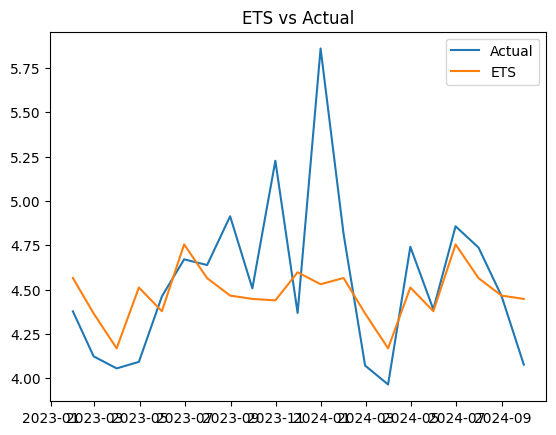

In [ ]:
plt.plot(test.index, test['Unemployment'], label='Actual')
plt.plot(test.index, forecast_ets, label='ETS')
plt.legend(); plt.title('ETS vs Actual'); plt.show()


In [ ]:
# Hybrid Model Placeholders
print("\nTo be implemented:")
print(" - ARIMA-ANN: Use ARIMA residuals as ANN input.")
print(" - SARIMA-SVM: Model SARIMA residuals using SVM.")


To be implemented:
 - ARIMA-ANN: Use ARIMA residuals as ANN input.
 - SARIMA-SVM: Model SARIMA residuals using SVM.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Train-test split
train = df['Unemployment'][:'2022']
test = df['Unemployment']['2023':]

# Step 1: ARIMA modeling
arima_model = ARIMA(train, order=(1, 1, 1))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=len(test))
arima_fitted = arima_result.fittedvalues
residuals = train - arima_fitted

In [ ]:
# Step 2: ANN on ARIMA residuals
X = []
y = []
lag = 3  # use last 3 residuals to predict next

residuals = residuals.dropna()

for i in range(lag, len(residuals)):
    X.append(residuals.values[i-lag:i])
    y.append(residuals.values[i])

X, y = np.array(X), np.array(y)


In [ ]:
# Train ANN
ann_model = MLPRegressor(hidden_layer_sizes=(10,), max_iter=500, random_state=42)
ann_model.fit(X, y)


MLPRegressor(hidden_layer_sizes=(10,), max_iter=500, random_state=42)

In [ ]:
# Forecast residuals using ANN
last_resid = residuals.values[-lag:]
forecast_ann = []

for _ in range(len(test)):
    pred = ann_model.predict(last_resid.reshape(1, -1))[0]
    forecast_ann.append(pred)
    last_resid = np.roll(last_resid, -1)
    last_resid[-1] = pred

In [ ]:
# Final forecast = ARIMA forecast + ANN forecast of residuals
final_forecast = arima_forecast.values + np.array(forecast_ann)


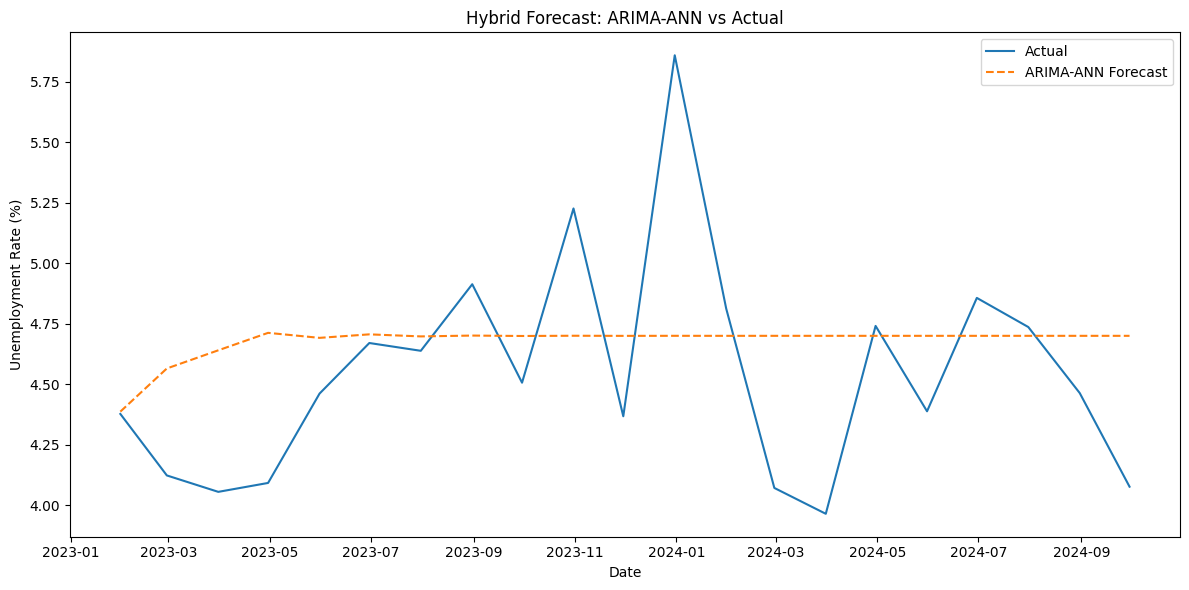

In [ ]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, final_forecast, label='ARIMA-ANN Forecast', linestyle='--')
plt.title('Hybrid Forecast: ARIMA-ANN vs Actual')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.savefig("arima_ann_forecast.png")
plt.show()

In [ ]:
# Evaluate
def evaluate(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

mae, rmse, mape = evaluate(test, final_forecast)
print("ARIMA-ANN Performance:")
print("MAE = {:.3f}".format(mae))
print("RMSE = {:.3f}".format(rmse))
print("MAPE = {:.2f}%".format(mape))

ARIMA-ANN Performance:
MAE = 0.347
RMSE = 0.453
MAPE = 7.75%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Train-test split
train = df['Unemployment'][:'2022']
test = df['Unemployment']['2023':]

# Step 1: SARIMA modeling
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.forecast(steps=len(test))
sarima_fitted = sarima_result.fittedvalues
residuals = train - sarima_fitted

In [ ]:

# Step 2: SVM on SARIMA residuals
X = []
y = []
lag = 3  # use last 3 residuals to predict next

residuals = residuals.dropna()

for i in range(lag, len(residuals)):
    X.append(residuals.values[i-lag:i])
    y.append(residuals.values[i])

X, y = np.array(X), np.array(y)


In [ ]:
# Train SVM
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)
svm_model.fit(X, y)

SVR(C=100, epsilon=0.01, gamma=0.1)

In [ ]:
# Forecast residuals using SVM
last_resid = residuals.values[-lag:]
forecast_svm = []

for _ in range(len(test)):
    pred = svm_model.predict(last_resid.reshape(1, -1))[0]
    forecast_svm.append(pred)
    last_resid = np.roll(last_resid, -1)
    last_resid[-1] = pred

In [ ]:
# Final forecast = SARIMA forecast + SVM forecast of residuals
final_forecast = sarima_forecast.values + np.array(forecast_svm)


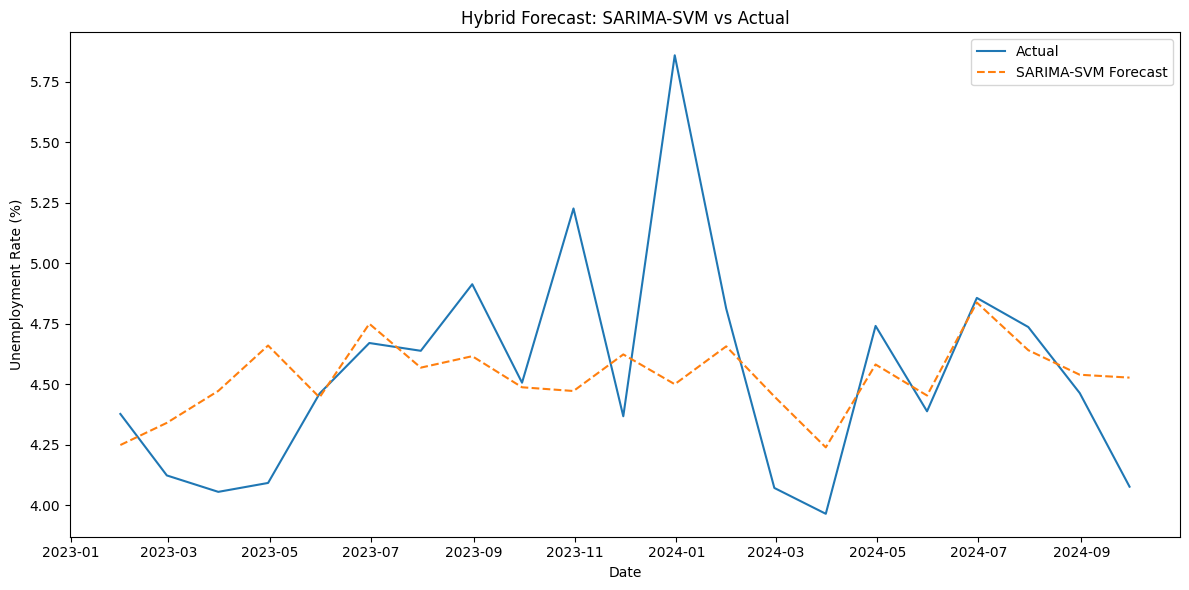

In [ ]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(test.index, final_forecast, label='SARIMA-SVM Forecast', linestyle='--')
plt.title('Hybrid Forecast: SARIMA-SVM vs Actual')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.tight_layout()
plt.savefig("sarima_svm_forecast.png")
plt.show()

In [ ]:
# Evaluate
def evaluate(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, rmse, mape

mae, rmse, mape = evaluate(test, final_forecast)
print("SARIMA-SVM Performance:")
print("MAE = {:.3f}".format(mae))
print("RMSE = {:.3f}".format(rmse))
print("MAPE = {:.2f}%".format(mape))

SARIMA-SVM Performance:
MAE = 0.279
RMSE = 0.416
MAPE = 5.97%


In [ ]:
# Data Preprocessing

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/malaysia_unemployment.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.asfreq('M')  # 'M' = monthly data

# Handle missing values
data.interpolate(method='linear', inplace=True)

# Normalize data
scaler = MinMaxScaler()
data[['GDP', 'Inflation']] = scaler.fit_transform(data[['GDP', 'Inflation']])

ADF Statistic: -14.310548038703557, p-value: 1.1863606041784523e-26


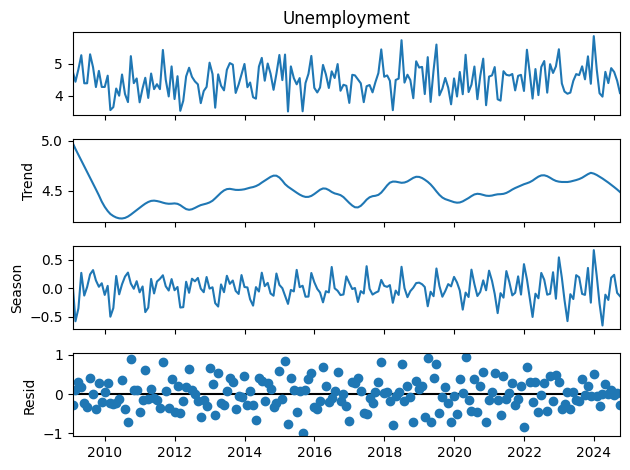

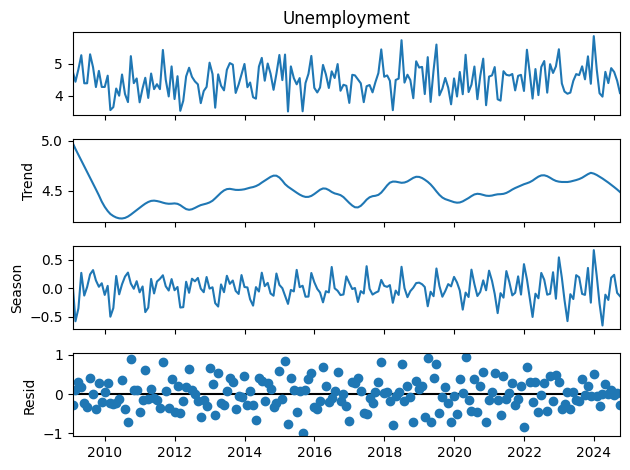

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL

# ADF Test for stationarity
adf_test = adfuller(data['Unemployment'])
print(f"ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}")

# STL Decomposition

from statsmodels.tsa.seasonal import STL

stl = STL(data['Unemployment'], seasonal=13)  # 12 = 12 months = 1 year
result = stl.fit()
result.plot()